# **Project Notebook**

This notebook contains the code work for Data Science project "Uncertainty quantification of deep neural networks for high-dimensional data" for the CS-E4875 course.

For the data I've decided to use the "Predict Student Performance from Game Play" dataset from Kaggle: https://www.kaggle.com/competitions/predict-student-performance-from-game-play/data?select=sample_submission.csv The data aims to predict students performance for questions, given their past performance. This is a proxy task for something I currently work on in my dayjob so it should pose an interesting problem to tackle. 

Let's load the the data and explore it a bit:

In [1]:
# imports
import pandas as pd
import dask.dataframe as dd
import dask
import pyarrow.parquet as pq

from functools import partial
from itertools import chain

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os




/opt/software/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


In [2]:
from datetime import date

today = date.today()

save_date = today.strftime("%d_%m_%Y")
print("run_date: ", save_date)

run_date:  22_04_2024


In [3]:
# CONSTANTS
MODEL_SAVE_PATH = "./saved_models/" 

## Helper scripts

In [4]:
# save the model to avoid need to rerun training every time

def handle_model(model_name, model, X, y, learner, epochs):
    full_model_path = MODEL_SAVE_PATH + model_name + ".pth"
    if os.path.exists(full_model_path):
        print("Model exists, loading...")
        model.load_state_dict(torch.load(full_model_path))
        model.eval()
        print("== Model loaded! == ")
    else:
        print("Model not found, training and saving...")
        learner.fit(X, y, epochs, batch_size=10)
        torch.save(model.state_dict(), full_model_path)
        print("== Model saved! == ")

## Model with mock data
I'll re-implement the model below, using the version from https://blog.ceshine.net/post/quantile-regression-part-2/#source-code

In [5]:
np.random.seed(100)

# ## Prepare Dataset

def f(x):
    """The function to predict."""
    return x * np.sin(x)

#----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)

# Observations
y = f(X).ravel()

dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

# Calculate bounds
n_std = 1.645  # For approximately 90% coverage
upper_bound = f(X).ravel() + n_std * dy
lower_bound = f(X).ravel() - n_std * dy

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)

X.shape, y.shape, xx.shape

((100, 1), (100,), (1000, 1))

In [6]:
class q_model(nn.Module):
    def __init__(self, 
                 quantiles, 
                 in_shape=1,  
                 dropout=0.5):     
        super().__init__()
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.in_shape = in_shape
        self.out_shape = len(quantiles)
        self.dropout = dropout
        self.build_model()
        self.init_weights()
        
    def build_model(self): 
        self.base_model = nn.Sequential(
            nn.Linear(self.in_shape, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
            nn.Linear(64, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
        )
        final_layers = [
            nn.Linear(64, 1) for _ in range(len(self.quantiles))
        ]
        self.final_layers = nn.ModuleList(final_layers)
        
    def init_weights(self):
        for m in chain(self.base_model, self.final_layers):
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight)
                nn.init.constant_(m.bias, 0)        
        
    def forward(self, x):
        tmp_ = self.base_model(x)
        return torch.cat([layer(tmp_) for layer in self.final_layers], dim=1)


class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles
        
    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(quantiles):
            errors = target - preds[:, i]
            losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))
        loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss


class Learner:
    def __init__(self, model, optimizer_class, loss_func, device='cpu'):
        self.model = model.to(device)
        self.optimizer = optimizer_class(self.model.parameters())
        self.loss_func = loss_func.to(device)
        self.device = device
        self.loss_history = []
        
    def fit(self, x, y, epochs, batch_size):
        self.model.train()
        for e in range(epochs):
            shuffle_idx = np.arange(x.shape[0])
            np.random.shuffle(shuffle_idx)
            x = x[shuffle_idx]
            y = y[shuffle_idx]
            epoch_losses = []
            for idx in range(0, x.shape[0], batch_size):
                self.optimizer.zero_grad()
                batch_x = torch.from_numpy(
                    x[idx : min(idx + batch_size, x.shape[0]),:]
                ).float().to(self.device).requires_grad_(False)
                batch_y = torch.from_numpy(
                    y[idx : min(idx + batch_size, y.shape[0])]
                ).float().to(self.device).requires_grad_(False)
                preds = self.model(batch_x)
                loss = loss_func(preds, batch_y)
                loss.backward()
                self.optimizer.step()
                epoch_losses.append(loss.cpu().detach().numpy())                                
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if (e+1) % 500 == 0:
                print("Epoch {}: {}".format(e+1, epoch_loss))
                
    def predict(self, x, mc=False):
        if mc:
            self.model.train()
        else:
            self.model.eval()
        return self.model(torch.from_numpy(x).to(self.device).requires_grad_(False)).cpu().detach().numpy()

In [7]:
# Instantiate model
quantiles = [.05, .5, .95]
model = q_model(quantiles, dropout=0.1)
loss_func = QuantileLoss(quantiles)
learner = Learner(model, partial(torch.optim.Adam, weight_decay=1e-6), loss_func)


## Train the Model

# Run training
epochs = 10000
#learner.fit(X, y, epochs, batch_size=10)

In [8]:
model_name = "one_dimensional_input_model"

handle_model(model_name, model, X, y, learner, epochs)

Model exists, loading...
== Model loaded! == 


## PLOT MODEL OUTPUTS

In [9]:
# Make the prediction on the meshed x-axis
predicted_percentiles = learner.predict(xx) # Assuming this gives [lower, median, upper]
y_lower_pred, y_pred, y_upper_pred = predicted_percentiles[:, 0], predicted_percentiles[:, 1], predicted_percentiles[:, 2]

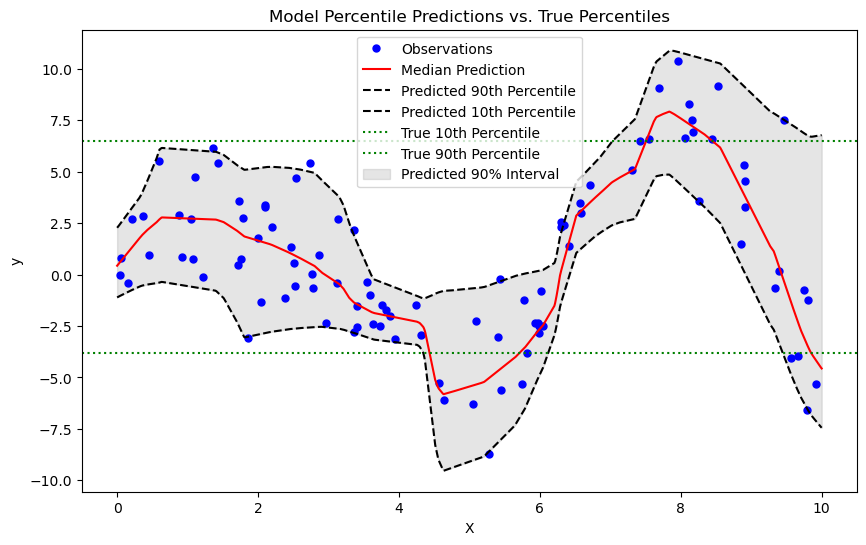

<Figure size 640x480 with 0 Axes>

In [10]:
# Plot the function, the prediction and the 90% confidence interval based on
# the MSE

# True Percentiles
y_lower_true = np.percentile(y, 10)
y_upper_true = np.percentile(y, 90)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X, y, 'b.', markersize=10, label='Observations')
plt.plot(xx, y_pred, 'r-', label='Median Prediction')
plt.plot(xx, y_upper_pred, 'k--', label='Predicted 90th Percentile')
plt.plot(xx, y_lower_pred, 'k--', label='Predicted 10th Percentile')
plt.axhline(y=y_lower_true, color='g', linestyle=':', label='True 10th Percentile')
plt.axhline(y=y_upper_true, color='g', linestyle=':', label='True 90th Percentile')
plt.fill_between(xx.ravel(), y_lower_pred, y_upper_pred, alpha=0.2, color='gray', label='Predicted 90% Interval')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Model Percentile Predictions vs. True Percentiles')
plt.legend()
plt.show()
plt.savefig('./images/prediction_dummy_data.png')
plt.show()

Percentage in the range (expecting 90%): 91.0
Percentage out of the range (expecting 10%): 9.0


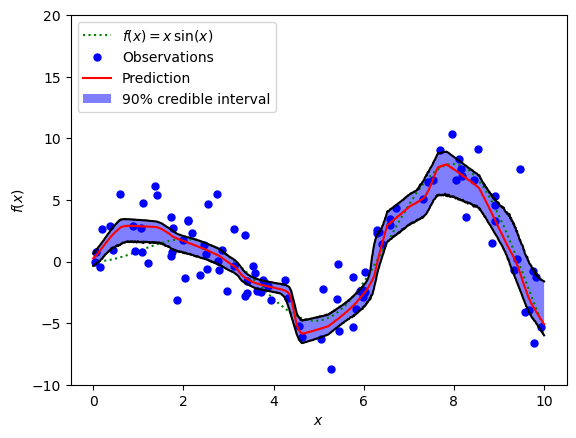

In [11]:
predictions = learner.predict(X)
np.mean(predictions[:, 0]), np.mean(predictions[:, 1]), np.mean(predictions[:, 2])


in_the_range = np.sum((y >= predictions[:, 0]) & (y <= predictions[:, 2]))
print("Percentage in the range (expecting 90%):", in_the_range / len(y) * 100)

out_of_the_range = np.sum((y < predictions[:, 0]) | (y > predictions[:, 2]))
print("Percentage out of the range (expecting 10%):", out_of_the_range / len(y)  * 100)


# ## MC Prediction

K = 5000
tmp = np.zeros((K, xx.shape[0])).astype("float32")
for k in range(K):
    preds = learner.predict(xx, mc=True)
    tmp[k] = preds[:, 1]
y_lower, y_pred, y_upper = np.percentile(tmp, (5, 50, 95), axis=0)    

y_lower[1], y_pred[1], y_upper[1]


# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% credible interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

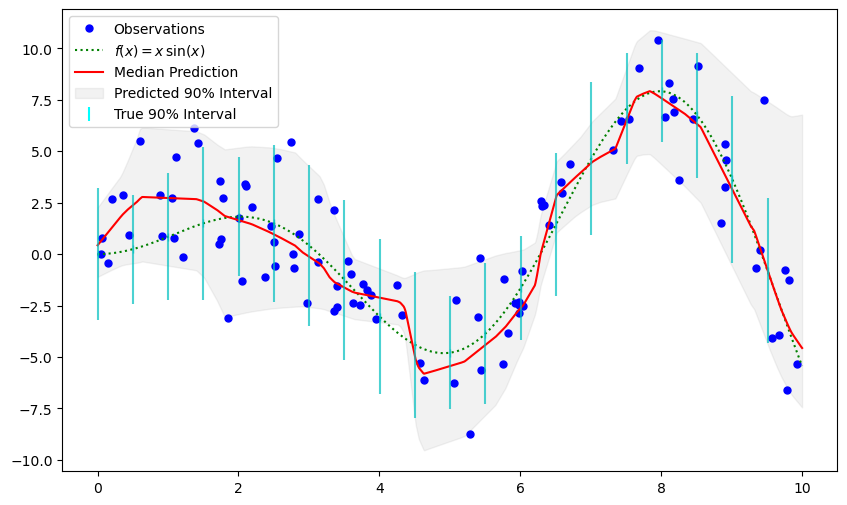

In [12]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

np.random.seed(100)

def f(x):
    return x * np.sin(x)

# Generate data
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)
y = f(X).ravel()
dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

# Predict percentiles using the model
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)
predicted_percentiles = learner.predict(xx) # Assuming this gives [lower, median, upper]
y_lower_pred, y_pred, y_upper_pred = predicted_percentiles[:, 0], predicted_percentiles[:, 1], predicted_percentiles[:, 2]

# Calculate dynamic true percentiles for each point in xx
dy_xx = 1.5 + 1.0 * np.random.random(xx.shape[0])  # Ensure dy_xx matches the length of xx
y_lower_true = f(xx).ravel() - 1.645 * dy_xx  # 10th percentile
y_upper_true = f(xx).ravel() + 1.645 * dy_xx  # 90th percentile

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X, y, 'b.', markersize=10, label='Observations')
plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(xx, y_pred, 'r-', label='Median Prediction')
plt.fill_between(xx.ravel(), y_lower_pred, y_upper_pred, alpha=0.1, color='gray', label='Predicted 90% Interval')

# Add vertical bars for true percentiles at regular intervals
interval = 50  # Interval for placing the vertical bars
for i in range(0, len(xx), interval):
    x_val = xx.ravel()[i]
    lower_val = y_lower_true[i]
    upper_val = y_upper_true[i]
    plt.errorbar(x_val, (lower_val + upper_val) / 2, yerr=[[(upper_val - lower_val) / 2]], fmt='c|', alpha=0.7)

vertical_bar_proxy = Line2D([0], [0], linestyle='none', marker='|', color='cyan', markersize=10, markeredgewidth=1.5)
    
# Automatically generate default legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
# Append the custom handler for the vertical bars
handles.append(vertical_bar_proxy)
labels.append('True 90% Interval')
plt.legend(handles=handles, labels=labels, loc="best")

plt.show()

## Extend the model to use two dimensions

In [13]:
## Build the Model

class q_model_multi_dimensional(nn.Module):
    def __init__(self, 
                 quantiles, 
                 in_shape=2,  
                 dropout=0.5):     
        super().__init__()
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.in_shape = in_shape
        self.out_shape = len(quantiles)
        self.dropout = dropout
        self.build_model()
        self.init_weights()
        
    def build_model(self): 
        self.base_model = nn.Sequential(
            nn.Linear(self.in_shape, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
            nn.Linear(64, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
        )
        final_layers = [
            nn.Linear(64, 1) for _ in range(len(self.quantiles))
        ]
        self.final_layers = nn.ModuleList(final_layers)
        
    def init_weights(self):
        for m in chain(self.base_model, self.final_layers):
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight)
                nn.init.constant_(m.bias, 0)        
        
    def forward(self, x):
        tmp_ = self.base_model(x)
        return torch.cat([layer(tmp_) for layer in self.final_layers], dim=1)


class QuantileLoss_2(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles
        
    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(quantiles):
            errors = target - preds[:, i]
            losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))
        loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss


class Learner_2:
    def __init__(self, model, optimizer_class, loss_func, device='cpu'):
        self.model = model.to(device)
        self.optimizer = optimizer_class(self.model.parameters())
        self.loss_func = loss_func.to(device)
        self.device = device
        self.loss_history = []
        
    def fit(self, x, y, epochs, batch_size):
        self.model.train()
        for e in range(epochs):
            shuffle_idx = np.arange(x.shape[0])
            np.random.shuffle(shuffle_idx)
            x = x[shuffle_idx]
            y = y[shuffle_idx]
            epoch_losses = []
            for idx in range(0, x.shape[0], batch_size):
                self.optimizer.zero_grad()
                batch_x = torch.from_numpy(
                    x[idx : min(idx + batch_size, x.shape[0]),:]
                ).float().to(self.device).requires_grad_(False)
                batch_y = torch.from_numpy(
                    y[idx : min(idx + batch_size, y.shape[0])]
                ).float().to(self.device).requires_grad_(False)
                preds = self.model(batch_x)
                loss = loss_func(preds, batch_y)
                loss.backward()
                self.optimizer.step()
                epoch_losses.append(loss.cpu().detach().numpy())                                
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if (e+1) % 500 == 0:
                print("Epoch {}: {}".format(e+1, epoch_loss))
                
    def predict(self, x, mc=False):
        if mc:
            self.model.train()
        else:
            self.model.eval()
        return self.model(torch.from_numpy(x).to(self.device).requires_grad_(False)).cpu().detach().numpy()

In [14]:
# Instantiate model for 2D data
quantiles = [.05, .5, .95]
model_2 = q_model_multi_dimensional(quantiles, in_shape=2, dropout=0.1)  # in_shape set to 2 for 2D input
loss_func_2 = QuantileLoss_2(quantiles)
learner_2 = Learner_2(model_2, partial(torch.optim.Adam, weight_decay=1e-6), loss_func_2)

# Define X and Y for two-dimensional input
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)
Y = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
Y = Y.astype(np.float32)

# Combine X and Y to create two-dimensional input data
XY = np.concatenate([X, Y], axis=1)

# Define the function for two-dimensional predictions
def g(x, y):
    """The function to predict in 2D."""
    return x * np.sin(x) + y * np.cos(y)

# Update observations for 2D
y_2 = g(XY[:, 0], XY[:, 1]).ravel()
dy = 1.5 + 1.0 * np.random.random(y_2.shape)  # Noise standard deviation
noise = np.random.normal(0, dy)
y_2 += noise
y_2 = y_2.astype(np.float32)

In [15]:
# Run training for 2D model
epochs = 5000
#learner_2.fit(XY, y_2, epochs, batch_size=10)

In [16]:
model_2_name = "two_dimensional_input_model"
handle_model(model_2_name, model_2, XY, y_2, learner_2, epochs)

Model exists, loading...
== Model loaded! == 


Assign index to training data to get uncertainty evaluation plot for multi-dimensional data 

In [125]:
# generate some data to test upon
X_test = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X_test = X_test.astype(np.float32)
Y_test = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
Y_test = Y_test.astype(np.float32)

test_data = np.concatenate([X_test, Y_test], axis=1)
print(len(test_data))

100


In [126]:
test_data.shape

(100, 2)

In [18]:
# Make the prediction on the meshed x-axis
predicted_percentiles = learner_2.predict(test_data)

y_lower_pred, y_pred, y_upper_pred = predicted_percentiles[:, 0], predicted_percentiles[:, 1], predicted_percentiles[:, 2]

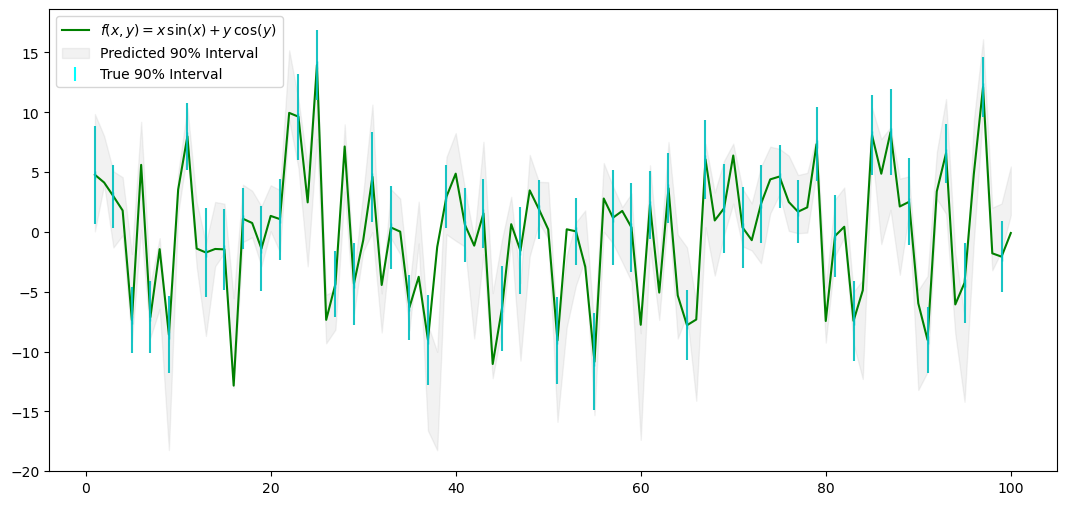

In [19]:
dy_test_data = 1.5 + 1.0 * np.random.random(test_data.shape[0])  # Ensure dy_xx matches the length of xx
y_lower_true = g(X_test, Y_test).ravel() - 1.645 * dy_test_data  # 10th percentile
y_upper_true = g(X_test, Y_test).ravel() + 1.645 * dy_test_data  # 90th percentile

# Plotting
plt.figure(figsize=(13, 6))

test_data_indexed = list(range(1, len(test_data) + 1))

#plt.plot(X_test, y_2, 'b.', markersize=10, label='Observations')
plt.plot(test_data_indexed, g(X_test, Y_test), 'g', label = r'$f(x, y) = x\,\sin(x) + y \,\cos(y)$')
#plt.plot(test_data_indexed, y_pred, 'r-', label='Median Prediction')
plt.fill_between(test_data_indexed, y_lower_pred, y_upper_pred, alpha=0.1, color='gray', label='Predicted 90% Interval')
#range(0, len(test_data), interval)
# Add vertical bars for true percentiles at regular intervals
interval = 2 # Interval for placing the vertical bars
for i in range(0, len(test_data), interval):
    x_val = test_data.ravel()[i]
    lower_val = y_lower_true[i]
    upper_val = y_upper_true[i]
    plt.errorbar(i+1, (lower_val + upper_val) / 2, yerr=[[(upper_val - lower_val) / 2]], fmt='c|', alpha=0.9)

# Automatically generate default legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
# Append the custom handler for the vertical bars
handles.append(vertical_bar_proxy)
labels.append('True 90% Interval')
plt.legend(handles=handles, labels=labels, loc="best")

plt.show()

In [20]:
# TODO: in the above graph add the y-values so they can be seen?

# this means that this should have the observation

# forgot what this was, maybe need to just add y for each linedot so that they can be more easily seen here?
# maybe also order this so its easy to see trends?

# Multi-dimensional model for real-data

In [21]:
# Instantiate model for 2D data
quantiles = [.05, .5, .95]
model_real_data = q_model_multi_dimensional(quantiles, in_shape=5, dropout=0.1)
#loss_func_multi = QuantileLoss_2(quantiles)
learner_real_data = Learner_2(model_real_data, partial(torch.optim.Adam, weight_decay=1e-6), loss_func_2)

## Review model results 

In [22]:
def calculate_picp(actual_values, lower_bounds, upper_bounds):
    """
    Calculate the Prediction Interval Coverage Probability (PICP).

    Parameters:
    actual_values (array-like): The actual observed values.
    lower_bounds (array-like): The lower bounds of the prediction intervals.
    upper_bounds (array-like): The upper bounds of the prediction intervals.

    Returns:
    float: The PICP value.
    """
    coverage = np.sum((actual_values >= lower_bounds) & (actual_values <= upper_bounds))
    picp = coverage / len(actual_values)
    return picp

def calculate_pinaw(actual_values, lower_bounds, upper_bounds):
    """
    Calculate the Prediction Interval Normalized Average Width (PINAW).

    Parameters:
    actual_values (array-like): The actual observed values.
    lower_bounds (array-like): The lower bounds of the prediction intervals.
    upper_bounds (array-like): The upper bounds of the prediction intervals.

    Returns:
    float: The PINAW value.
    """
    interval_widths = upper_bounds - lower_bounds
    data_range = np.max(actual_values) - np.min(actual_values)
    normalized_widths = interval_widths / data_range
    pinaw = np.mean(normalized_widths)
    return pinaw

def calculate_cwc(actual_values, lower_bounds, upper_bounds, picp_threshold=0.9):
    """
    Calculate the Coverage Width-based Criterion (CWC).

    Parameters:
    actual_values (array-like): The actual observed values.
    lower_bounds (array-like): The lower bounds of the prediction intervals.
    upper_bounds (array-like): The upper bounds of the prediction intervals.
    picp_threshold (float): The desired threshold for PICP.

    Returns:
    float: The CWC value.
    """
    picp = calculate_picp(actual_values, lower_bounds, upper_bounds)
    pinaw = calculate_pinaw(actual_values, lower_bounds, upper_bounds)
    
    # CWC formula can vary. Here's one common approach:
    if picp < picp_threshold:
        cwc = pinaw * (1 + np.exp(-10 * (picp - picp_threshold)))
    else:
        cwc = pinaw

    return cwc

## Real data for the model

To continue modeling with more realistic data I chose house prices for advanced regression dataset from Kaggle: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

As Kaggle data is made for competing, the test data does not actually contain the sale price value which we are trying to predict. Therefore we must use the training data both for training and testing the model so we'll split it into two (other ways to trainsplit can be considered in the future): 

In [23]:
from sklearn.preprocessing import OneHotEncoder

In [24]:
train_df = pd.read_csv("data/train.csv")
train_df = train_df.drop('Id', axis=1)

In [25]:
display(train_df.head(3))
display(train_df.columns)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [76]:
selected_cols_test_df = train_df[["MSSubClass", "LotArea", "YrSold", "OverallCond", "SalePrice"]].copy()

#encoder = OneHotEncoder(sparse_output=False)
#encoded_data = encoder.fit_transform(train_df[['HouseStyle']])

#encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())

#X_real.loc[:, 'HouseStyle'] = encoded_df.apply(lambda row: row.to_numpy(), axis=1)
#y_real = train_df["SalePrice"].values


In [117]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

training_data, test_data = split_dataset(selected_cols_test_df)
print("{} examples in training, {} examples in testing.".format(
    len(X_real), len(y_real)))




4 examples in training, 1 examples in testing.


In [118]:
X_real = training_data[["MSSubClass", "LotArea", "YrSold", "OverallCond"]]
y_real = training_data[["SalePrice"]]

In [119]:
X_real.describe()

,MSSubClass,LotArea,YrSold,OverallCond
count,1199.000000,1199.000000,1199.000000,1199.000000
mean,57.677231,10630.129274,2007.829858,5.576314
std,42.995672,10752.437950,1.312992,1.101966
min,20.000000,1300.000000,2006.000000,1.000000
25%,20.000000,7581.000000,2007.000000,5.000000
50%,50.000000,9477.000000,2008.000000,5.000000
75%,70.000000,11500.000000,2009.000000,6.000000
max,190.000000,215245.000000,2010.000000,9.000000


In [120]:
display(X_real.shape)
display(y_real.shape)

(1199, 4)

(1199, 1)

In [121]:
X_real = X_real.to_numpy()
y_real = y_real.to_numpy().T

In [122]:
quantiles = [.05, .5, .95]
model_real_data = q_model_multi_dimensional(quantiles, in_shape=5, dropout=0.1)
learner_real_data = Learner_2(model_real_data, partial(torch.optim.Adam, weight_decay=1e-6), loss_func_2)

In [123]:
real_data_model_name = "multi_dimensional_real_input_model"
epochs = 2000
handle_model(real_data_model_name, model_real_data, X_real, y_real, learner_real_data, epochs)

Model not found, training and saving...


IndexError: index 234 is out of bounds for axis 0 with size 1

In [116]:
tmp

array([[ 4.1850752e-01, -3.3372036e-01, -4.5342413e-01, ...,
        -5.0851560e+00, -5.5807357e+00, -5.5158978e+00],
       [-1.6234291e-01,  3.6827594e-01,  2.0556092e-01, ...,
        -1.5332856e+00, -5.4696746e+00, -5.7691345e+00],
       [ 2.0726663e-01,  4.5479518e-01, -3.0359030e-03, ...,
        -5.7185445e+00, -1.6120747e+00, -3.3288543e+00],
       ...,
       [ 3.0159950e-03,  4.0222090e-01,  6.2739462e-01, ...,
        -4.2750335e+00, -5.1891165e+00, -5.8199911e+00],
       [ 4.8905593e-01,  3.3207220e-01,  7.4411076e-01, ...,
        -5.2333579e+00, -5.5772896e+00, -5.0695190e+00],
       [ 2.6058465e-01, -1.4146966e-01,  1.8362457e-01, ...,
        -2.6101332e+00, -4.8599834e+00, -4.8443127e+00]], dtype=float32)

In [ ]:
y_lower, y_pred, y_upper = tmp[:, 0], tmp[:, 1], tmp[:, 2]

# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure()
#plt.plot(xx, f(xx), 'g:', label='MSSubClass')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(values_to_predict, y_pred, 'r-', label=u'Prediction')
plt.plot(values_to_predict, y_upper, 'k-')
plt.plot(values_to_predict, y_lower, 'k-')
plt.fill(np.concatenate([values_to_predict, values_to_predict[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
#plt.xlabel('$x$')
#plt.ylabel('$f(x)$')
#plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

Extend the new data to new dimension